# Spacetime Ripple Simulation with Relativistic Effects

This notebook demonstrates the behavior of particles and wave functions in a 4D spacetime grid. It includes:
- Converting between 4D spherical and Cartesian coordinates.
- Simulating wave propagation.
- Modeling particle paths with relativistic effects.
- Visualizing results.

In [1]:
# Import Required Libraries
from scipy.constants import c as speed_of_light
from numba import njit
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline


## Define StateSpace Class
This class contains functions for:
- Converting between 4D spherical and Cartesian coordinates.
- Computing relativistic effects such as time dilation and wave propagation.
- Modeling spin and antiparticle wave functions.

In [2]:
class QuantumWaveSimulator:
    def __init__(self, L, T, c, dx, dt, m=0):
        """
        Initialize simulation parameters.
        """
        self.L = L  # Length of spatial domain
        self.T = T  # Total simulation time
        self.c = c  # Speed of light
        self.dx = dx  # Spatial resolution
        self.dt = dt  # Time step size
        self.m = m  # Mass term

        self.nx = int(L / dx) + 1
        self.nt = int(T / dt) + 1

        self.x = np.linspace(-L / 2, L / 2, self.nx)  # Spatial grid
        self.t = np.linspace(0, T, self.nt)  # Time grid

        # Wavefunction initialization
        self.Psi = np.zeros((self.nt, self.nx))  # Wavefunction for Klein-Gordon
        self.energy = np.zeros(self.nt)  # Total energy over time

        # NEW: Potential array (initially zero - no effect)
        self.V = np.zeros(self.nx)

    def initialize_particle(self, mode="single", A=1, k=2 * np.pi, phi=0, set_initial_velocity=True):
        """
        Initialize the wavefunction based on the specified mode.
        """
        if mode == "single":
            self.Psi[0, :] = A * np.exp(-0.5 * (self.x / self.L) ** 2) * np.cos(k * self.x + phi)
        elif mode == "entangled":
            self.Psi[0, :] = (
                A * np.exp(-0.5 * ((self.x - self.L / 4)) ** 2) +
                A * np.exp(-0.5 * ((self.x + self.L / 4)) ** 2)
            )
        elif mode == "superposition":
            self.Psi[0, :] = (
                A * np.cos(k * self.x + phi) + A * np.cos(-k * self.x + phi)
            )
        # NEW MODE: complex_gaussian for phase testing
        elif mode == "complex_gaussian":
            # Complex Gaussian with a plane wave factor for phase variation
            # Convert Psi to complex array to store complex values
            self.Psi = self.Psi.astype(complex)
            self.Psi[0, :] = A * np.exp(-0.5 * (self.x/(self.L/5))**2) * np.exp(1j*(k*self.x + phi))
        else:
            raise ValueError("Mode must be 'single', 'entangled', 'superposition', or 'complex_gaussian'.")

        # For the next time step, if complex:
        if set_initial_velocity:
            self.Psi[1, :] = (
                self.Psi[0, :] + self.dt * self.initial_wave_velocity(self.x, A=A, k=k, phi=phi)
            )
        else:
            # Assume zero initial time derivative for simplicity
            self.Psi[1, :] = self.Psi[0, :]

        self.mode = mode

    def initial_wave_velocity(self, x, A=1, k=2 * np.pi, phi=0):
        """
        Initialize the wavefunction's time derivative.
        """
        return -A * self.c * k * np.sin(k * x + phi) 
    
    @staticmethod
    @njit
    def solve_klein_gordon(Psi, nt, nx, c, dt, dx, m2):
        """
        Solve the Klein-Gordon equation.
        """
        for n in range(1, nt - 1):
            for i in range(1, nx - 1):
                Psi[n + 1, i] = (
                    2 * Psi[n, i]
                    - Psi[n - 1, i]
                    + (c * dt / dx) ** 2 * (Psi[n, i + 1] - 2 * Psi[n, i] + Psi[n, i - 1])
                    - (dt ** 2) * m2 * Psi[n, i]
                )

            # Check for numerical stability
            if np.any(np.isnan(Psi[n + 1, :])) or np.any(np.isinf(Psi[n + 1, :])):
                raise ValueError(f"Numerical instability detected at step {n}.")
        return Psi
    
    @staticmethod
    @njit
    def solve_klein_gordon_with_potential(Psi, V, nt, nx, c, dt, dx, m2):
        """
        Solve the Klein-Gordon equation with a potential V(x).
        """
        for n in range(1, nt - 1):
            for i in range(1, nx - 1):
                Psi[n + 1, i] = (
                    2 * Psi[n, i]
                    - Psi[n - 1, i]
                    + (c * dt / dx) ** 2 * (Psi[n, i + 1] - 2 * Psi[n, i] + Psi[n, i - 1])
                    - dt**2 * (m2 + V[i]) * Psi[n, i]
                )
            if np.any(np.isnan(Psi[n + 1, :])) or np.any(np.isinf(Psi[n + 1, :])):
                raise ValueError(f"Numerical instability detected at step {n}.")
        return Psi
    
    def solve(self, include_potential=False):
        """
        Solve the Klein-Gordon equation, optionally including a potential V(x).
        """
        m2 = (self.m / self.c) ** 2
        if include_potential:
            self.Psi = self.solve_klein_gordon_with_potential(self.Psi, self.V, self.nt, self.nx, self.c, self.dt, self.dx, m2)
        else:
            self.Psi = self.solve_klein_gordon(self.Psi, self.nt, self.nx, self.c, self.dt, self.dx, m2)
        self.compute_energy()
    
    def set_single_barrier_potential(self, height=1000, width=0.2, center=0):
        """
        Define a single potential barrier or well.
        """
        self.V[:] = 0
        barrier_indices = np.where(
            (self.x > center - width / 2) & (self.x < center + width / 2)
        )[0]
        self.V[barrier_indices] = height
        
    def compute_energy(self):
        """
        Compute and store the total energy of the system over time.
        """
        for n in range(1, self.nt - 1):
            # Kinetic energy
            time_derivative = (self.Psi[n + 1, :] - self.Psi[n - 1, :]) / (2 * self.dt)
            kinetic_energy = 0.5 * np.abs(time_derivative) ** 2

            # Potential energy (using absolute values for complex fields)
            space_derivative = np.zeros_like(self.Psi[n, :], dtype=complex)
            space_derivative[1:-1] = (self.Psi[n, 2:] - self.Psi[n, :-2]) / (2 * self.dx)
            potential_energy = 0.5 * (
                (self.c ** 2) * np.abs(space_derivative) ** 2 + (self.m ** 2) * np.abs(self.Psi[n, :]) ** 2
            )

            # Total energy density
            self.energy[n] = np.sum(kinetic_energy + potential_energy) * self.dx  # Integrate over space

    #Method to set a double-slit potential. Not currently used in solve().
    #      This will not break existing code since solve() does not depend on V.
    def set_double_slit_potential(self, barrier_height=1e3, slit_width=0.05, slit_separation=0.4):
        """
        Define a double-slit potential (for future use).
        This does not affect the current solver as we do not apply V yet.
        """
        self.V[:] = barrier_height
        slit1_center = -slit_separation / 2.0
        slit2_center = slit_separation / 2.0
        slit1_indices = np.where((self.x > slit1_center - slit_width/2) & (self.x < slit1_center + slit_width/2))[0]
        slit2_indices = np.where((self.x > slit2_center - slit_width/2) & (self.x < slit2_center + slit_width/2))[0]

        self.V[slit1_indices] = 0.0
        self.V[slit2_indices] = 0.0

    # A method to apply a global phase shift to the initial wavefunction.
    #      This is optional and won't break the existing code if not used.
    #      Since Psi is initially real, we convert it to complex before adding a phase.
    def apply_phase_shift(self, phase=0.0):
        """
        Apply a global phase shift to the initial wavefunction.
        This is a simple demonstration. The solver still treats Psi as real,
        but adding a global phase factor won't break anything.
        """
        # Convert Psi to complex if not already
        if self.Psi.dtype != complex:
            self.Psi = self.Psi.astype(complex)

        self.Psi[0, :] *= np.exp(1j * phase)
        self.Psi[1, :] *= np.exp(1j * phase)

    def visualize_energy(self, name=""):
        """
        Plot the total energy over time from -T to T.
        """
        # Assuming self.t goes from 0 to T originally:
        T_max = self.t[-1]
        # Create a symmetric time array from -T to T
        t_sym = np.linspace(-T_max, T_max, 2 * len(self.t))
        
        # Construct a symmetric energy array:
        # Forward half (0 to T): self.energy
        # Negative half (-T to 0): We'll assume energy is even and mirror it.
        # If you have a reasoned definition for negative times, replace accordingly.
        energy_sym = np.concatenate((-self.energy[::-1], self.energy))
        
        plt.figure(figsize=(8, 5))
        plt.plot(t_sym, energy_sym, label="Total Energy", color="blue")
        plt.xlabel("Time $t$")
        plt.ylabel(f"{self.mode} Wavefunction Ψ - Total Energy $E(t)$")
        plt.title("Energy Conservation from -T to T")
        plt.legend()
        plt.grid()
        plt.savefig(f'energy_conservation_{self.mode if name == "" else name}.png')
        plt.show()
    
    def visualize_wave(self, localize=True, show_phase=False):
        """
        Visualize the wavefunction over space and time.
        """
        plt.figure(figsize=(10, 6))
        
        if show_phase:
            # Compute amplitude and phase
            if localize:
                amplitude_val = np.abs(self.Psi)**2
            else:
                amplitude_val = np.abs(self.Psi)
            phase_val = np.angle(self.Psi)
            
            # Normalize amplitude for brightness
            amp_norm = amplitude_val / amplitude_val.max()
            # Convert phase from [-π, π] to [0,1) for hue
            # (phase_val + π) shifts range: [-π, π] -> [0, 2π)
            # % (2*np.pi) ensures wrap-around within [0, 2π)
            # dividing by (2*np.pi) maps [0, 2π) -> [0,1)
            forward_phase = ((phase_val + np.pi) % (2*np.pi)) / (2*np.pi)
            conjugate_phase = ((phase_val ) % (2*np.pi)) / (2*np.pi)
            # Combine as done previously:
            # For simplicity, we can just show forward amplitude.
            # The original code concatenated forward and conjugate arrays, but let's keep consistent:
            amplitude = np.concatenate(
                [amp_norm[::-1, ::-1], amp_norm[:, ::-1]], axis=0
            )
            # Phase should match this arrangement
            phase_combined = np.concatenate(
                [conjugate_phase[::-1, ::-1], forward_phase[:, ::-1]], axis=0
            )
            # Build HSV image: H=phase_combined, S=1, V=amplitude
            hsv = np.zeros((amplitude.shape[0], amplitude.shape[1], 3))
            hsv[...,0] = phase_combined   # hue
            hsv[...,1] = 1            # saturation
            hsv[...,2] = amplitude     # value
            rgb = matplotlib.colors.hsv_to_rgb(hsv)
            cmap = 'hsv'  # We'll plot rgb directly
            img_data = rgb
            label = "Amplitude & Phase (Hue=Phase)"
        else:
            # Original code for amplitude-only plotting
            if localize:
                forward_amplitude =  np.abs(self.Psi) ** 2
                cmap = 'plasma'
            else:
                forward_amplitude =  np.abs(self.Psi)
                cmap = 'viridis'

            amplitude = np.concatenate(
                [-forward_amplitude[::-1, ::-1], forward_amplitude[:,::-1]], axis=0
            )
            img_data = amplitude
            label = "|Ψ|^2" if localize else "|Ψ|"

        extent = [-self.L / 2, self.L / 2, -self.T, self.T]
        plt.imshow(
            img_data,
            extent=extent,
            origin="lower",
            aspect="auto",
            cmap=cmap,
        )
        plt.colorbar(label=label)
        plt.xlabel("Position $x$")
        plt.ylabel("Time $t$")
        plt.title(f"{self.mode} Wavefunction Ψ - Wave Propagation")
        plt.savefig(f'{self.mode}_wavefunction{"_probability_density" if localize else ""}{ "_with_phase" if show_phase else ""}.png')
        plt.show()

    def visualize_2D_ripple_polar(self, localize=True, show_phase=True):
        """
        Create a 2D polar ripple visualization with amplitude and phase mapping.
        
        Parameters:
        - localize (bool): If True, applies localization to the amplitude.
        - show_phase (bool): If True, includes phase information in the plot.
        """
        # Validate required attributes
        required_attrs = ['Psi', 't', 'nt', 'nx', 'c', 'mode', 'L', 'T']
        for attr in required_attrs:
            if not hasattr(self, attr):
                raise AttributeError(f"The object must have '{attr}' attribute.")

        # Prepare time and spatial grid
        sample_rate = max(1, self.nt // 100)
        time_steps = np.arange(0, self.nt, sample_rate)

        # Polar grid setup
        theta = np.linspace(0, 2 * np.pi, 2 * self.nx, endpoint=False)
        r = self.c * self.t[time_steps]
        TH, R = np.meshgrid(theta, r)

        # Amplitude and phase computation

        # Localization (if enabled)
        if localize:
            amplitude_val = np.abs(self.Psi[time_steps])**2
        else:
            amplitude_val = np.abs(self.Psi[time_steps])
        phase_val = np.angle(self.Psi[time_steps])
     
        # Normalize amplitude and phase to match `visualize_wave`
        amp_max = amplitude_val.max() or 1  # Prevent division by zero
        amp_norm = amplitude_val / amp_max

        # Convert phase from [-π, π] to [0,1) for hue
        # (phase_val + π) shifts range: [-π, π] -> [0, 2π)
        # % (2*np.pi) ensures wrap-around within [0, 2π)
        # dividing by (2*np.pi) maps [0, 2π) -> [0,1)
        forward_phase = ((phase_val + np.pi) % (2*np.pi)) / (2*np.pi)
        conjugate_phase = ((phase_val ) % (2*np.pi)) / (2*np.pi)
        # Combine as done previously:
        # For simplicity, we can just show forward amplitude.
        if show_phase:
            conjugate_amp = amp_norm
        else:
            conjugate_amp = -amp_norm
        # The original code concatenated forward and conjugate arrays, but let's keep consistent:
        amp_norm = np.concatenate(
            [conjugate_amp, amp_norm[:, ::-1]], axis=1
        )
        # Phase should match this arrangement
        phase_norm = np.concatenate(
            [conjugate_phase,forward_phase[:, ::-1]], axis=1
        )


        # Plotting with `pcolormesh`
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(12, 8))
        R_plot, TH_plot = R[:-1, :-1], TH[:-1, :-1]
        if show_phase:
            # Build HSV image: Hue = phase, Saturation = 1, Value = amplitude
            hsv = np.zeros((amp_norm.shape[0], amp_norm.shape[1], 3))
            hsv[..., 0] = phase_norm   # Hue
            hsv[..., 1] = 1.0          # Saturation
            hsv[..., 2] = amp_norm     # Value (brightness)
            rgb = matplotlib.colors.hsv_to_rgb(hsv)
            rgb_plot = rgb[:-1, :-1, :]
            pcm = ax.pcolormesh(TH_plot, R_plot, rgb[:-1, :-1, :], shading='auto')
            pcm.set_facecolors(rgb_plot.reshape(-1, 3))
            cmap = 'hsv'
        else: 
            cmap = 'plasma' if localize else 'viridis'
            pcm = ax.pcolormesh(TH_plot, R_plot, amp_norm[:-1, :-1],cmap=cmap, shading='auto')

        # Colorbar
        sm_phase = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-np.pi, vmax=np.pi))
        sm_phase.set_array([])
        cbar_phase = fig.colorbar(sm_phase, ax=ax, pad=0.1, orientation='vertical')
        cbar_phase.set_label('Phase (radians)', fontsize=12)

        # Title and layout
        ax.set_title(f"{self.mode} Wavefunction Ψ - 2D Polar Ripple (-T to T)", fontsize=16, pad=20)
        ax.set_theta_zero_location("E")
        ax.set_theta_direction(-1)
        plt.tight_layout()
        plt.savefig(f'{self.mode}_wavefunction_2d_polar{"_probability_density" if localize else ""}{ "_with_phase" if show_phase else ""}.png')
        plt.show()

    def visualize_3D_ripple_polar(self, localize=True, show_phase=True):
        """
        Create a 3D polar ripple visualization with amplitude and phase mapping.
        
        Zero amplitude (0) appears black, and color intensity is modulated based on amplitude.
        
        Parameters:
        - localize (bool): If True, applies localization to the amplitude.
        - show_phase (bool): If True, overlays phase information using color (RGB).
        """
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        # Prepare grid for polar coordinates
        theta = np.linspace(0, 2 * np.pi, self.nx * 2)  # Full angular domain (0 to 360°)
        r = self.c * self.t  # Radius grows with time
        Theta, R = np.meshgrid(theta, r)

        # Compute amplitudes for forward and conjugate wavefunctions
        if localize:
            forward_amplitude = np.abs(self.Psi)**2
            conjugate_amplitude = np.abs(self.Psi[:, ::-1])**2
        else:
            forward_amplitude = np.abs(self.Psi)
            conjugate_amplitude = np.abs(self.Psi[:, ::-1])

        # Normalize amplitudes to desired ranges
        forward_amplitude = 0.5 + 0.5 * (forward_amplitude / forward_amplitude.max())
        conjugate_amplitude = 0.5 - 0.5 * (conjugate_amplitude / conjugate_amplitude.max())

        # Combine amplitudes for 360° visualization
        amplitude_combined = np.concatenate(
            [forward_amplitude, conjugate_amplitude], axis=1
        )

        # Compute phase and adjust based on amplitude
        if show_phase:
            phase_val = np.angle(self.Psi)

            forward_phase = ((phase_val + np.pi) % (2*np.pi)) / (2*np.pi)
            conjugate_phase = ((phase_val ) % (2*np.pi)) / (2*np.pi)

            # Phase should match this arrangement
            phase_norm = np.concatenate(
                [forward_phase,conjugate_phase[:, ::-1]], axis=1
            )

            # Adjust hue based on amplitude
            hue = np.zeros_like(amplitude_combined)
            hue[amplitude_combined > 0.500000] = phase_norm[amplitude_combined > 0.500000]  # Matter (positive energy)
            hue[amplitude_combined < 0.500000] = phase_norm[amplitude_combined < 0.500000]  # Antimatter (negative energy)

            # Set saturation and brightness based on amplitude
            saturation = np.ones_like(amplitude_combined)
            brightness = np.abs(amplitude_combined - 0.5) * 2  # Map [0.5 ± 0.5] to [0, 1]

            # Build HSV image
            hsv = np.zeros((amplitude_combined.shape[0], amplitude_combined.shape[1], 3))
            hsv[..., 0] = hue  # Hue
            hsv[..., 1] = saturation  # Saturation
            hsv[..., 2] = brightness  # Brightness (Value)
            rgb = matplotlib.colors.hsv_to_rgb(hsv)  # Convert HSV to RGB

            # Reduce RGB intensity based on brightness
            rgb *= brightness[..., np.newaxis]
        else:
            rgb = None  # No color overlay if `show_phase` is False

        # Convert polar coordinates to Cartesian for 3D plotting
        X = R * np.cos(Theta)
        Y = R * np.sin(Theta)
        Z = amplitude_combined

        # Plot the surface with or without RGB overlay
        if show_phase:
            # Map RGB colors to the surface
            surf = ax.plot_surface(
                X, Y, Z, facecolors=rgb[:-1, :-1, :], edgecolor='none', rstride=1, cstride=1, shade=False
            )
        else:
            # Use a colormap for amplitude-only visualization
            cmap = 'plasma' if localize else 'viridis'
            surf = ax.plot_surface(
                X, Y, Z, cmap=cmap, edgecolor='none', rstride=1, cstride=1, alpha=0.8
            )

        # Add colorbar and labels
        if show_phase:
            # Add a colorbar for hue (phase)
            mappable = plt.cm.ScalarMappable(cmap='hsv', norm=plt.Normalize(vmin=-np.pi, vmax=np.pi))
            mappable.set_array([])
            fig.colorbar(mappable, ax=ax, label="Phase (radians)")
        else:
            fig.colorbar(surf, ax=ax, label='Amplitude')

        ax.set_title(f"{self.mode} Wavefunction Ψ - 3D Polar Ripple Visualization")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Amplitude (Normalized)")
        plt.savefig(f'{self.mode}_wavefunction_3d_polar{"_probability_density" if localize else ""}{ "_with_phase" if show_phase else ""}.png')
        plt.show()



## Simulate Wave Propagation
We solve the Klein-Gordon wave equation in 1D.

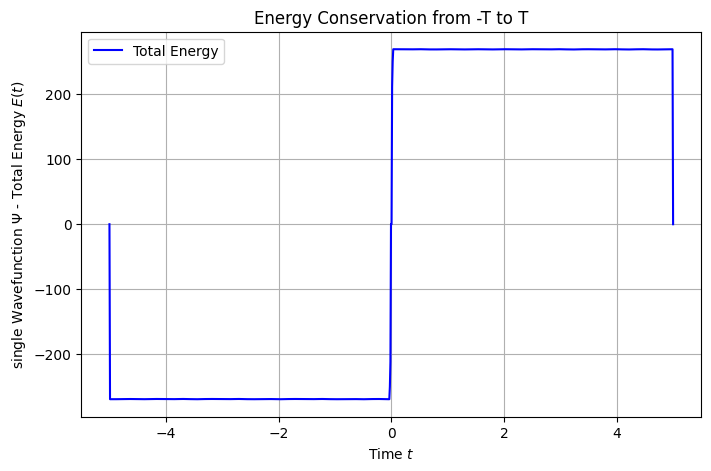

In [4]:
#Single Gaussian wave packet
simulator = QuantumWaveSimulator(L=10, T=5, c=1, dx=0.01, dt=0.01, m=1)
simulator.initialize_particle(mode="single", A=1, k=2 * np.pi, phi=0)
simulator.solve()
simulator.visualize_energy(name="gaussian")

# simulator.visualize_wave(localize=False, show_phase=False)
# simulator.visualize_2D_ripple_polar(localize=False, show_phase=False)
# simulator.visualize_3D_ripple_polar(localize=False, show_phase=False)

# simulator.visualize_wave(localize=False, show_phase=True)
# simulator.visualize_2D_ripple_polar(localize=False, show_phase=True)
# simulator.visualize_3D_ripple_polar(localize=False, show_phase=True)

# simulator.visualize_wave(localize=True, show_phase=False)
# simulator.visualize_2D_ripple_polar(localize=True, show_phase=False)
# simulator.visualize_3D_ripple_polar(localize=True, show_phase=False)

# simulator.visualize_wave(localize=True, show_phase=True)
# simulator.visualize_2D_ripple_polar(localize=True, show_phase=True)
# simulator.visualize_3D_ripple_polar(localize=True, show_phase=True)

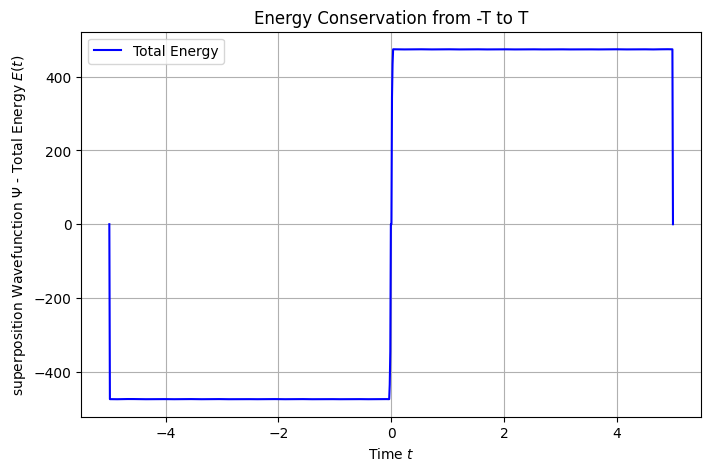

In [5]:
simulator = QuantumWaveSimulator(L=10, T=5, c=1, dx=0.01, dt=0.01, m=1)
simulator.initialize_particle(mode="superposition", A=1, k=2 * np.pi, phi=np.pi/4)
simulator.solve()
simulator.visualize_energy(name="superposition")

# simulator.visualize_wave(show_phase=True)
# simulator.visualize_2D_ripple_polar(show_phase=True)
# simulator.visualize_3D_ripple_polar(show_phase=True)

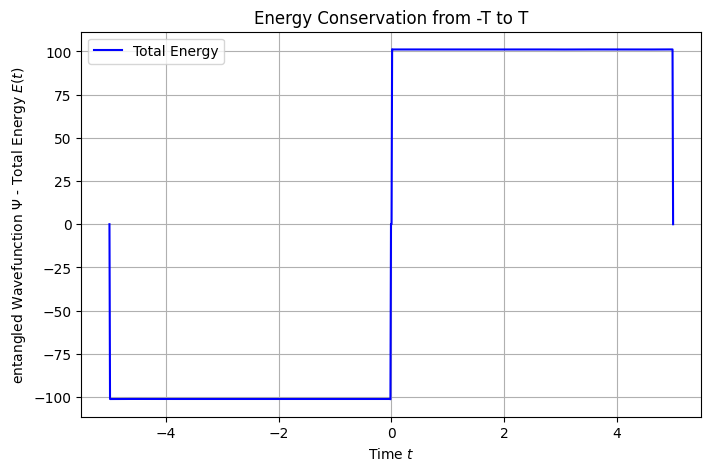

In [6]:
simulator = QuantumWaveSimulator(L=10, T=5, c=1, dx=0.01, dt=0.01, m=1)
simulator.initialize_particle(mode="entangled", A=1, k=2 * np.pi, phi=np.pi/4)
simulator.solve()
simulator.visualize_energy(name="entangled")

# simulator.visualize_wave(show_phase=True)
# simulator.visualize_2D_ripple_polar(show_phase=True)
# simulator.visualize_3D_ripple_polar(show_phase=True)

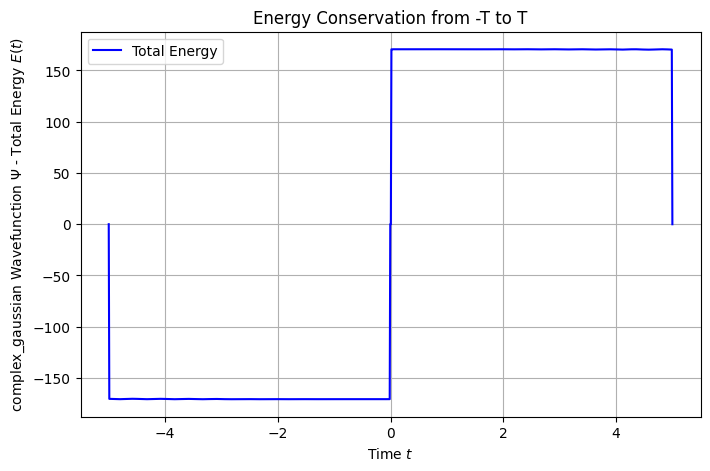

In [24]:
simulator = QuantumWaveSimulator(L=10, T=5, c=1, dx=0.01, dt=0.01, m=1)
simulator.initialize_particle(mode="complex_gaussian", A=1, k=2 * np.pi, phi=np.pi/4, set_initial_velocity=True)
simulator.solve()
simulator.visualize_energy(name="complex_gaussian")

# simulator.visualize_wave(localize=False, show_phase=True)
# simulator.visualize_2D_ripple_polar(localize=False, show_phase=True)
# simulator.visualize_3D_ripple_polar(localize=False, show_phase=True)

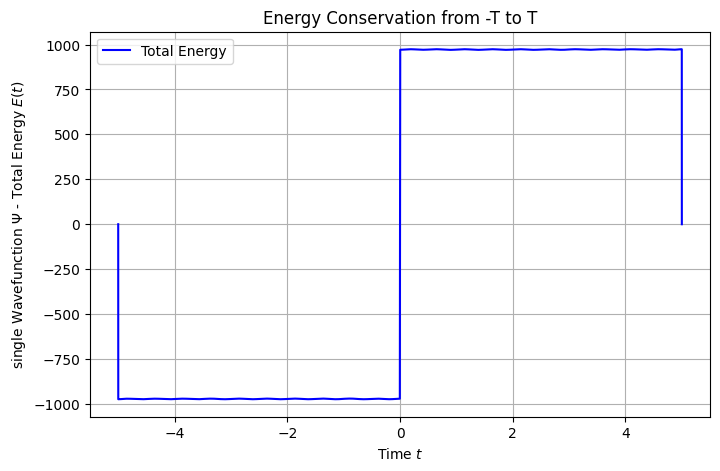

In [8]:
simulator = QuantumWaveSimulator(L=10, T=5, c=1, dx=0.001, dt=0.001, m=1)
simulator.initialize_particle(mode="single", A=1, k=2 * np.pi, phi=0)
simulator.set_single_barrier_potential(height=36.5, width=0.2, center=0)
simulator.solve(include_potential=True)
simulator.visualize_energy(name="tunneling")

#simulator.visualize_wave(show_phase=True)
#simulator.visualize_2D_ripple_polar(show_phase=True)
#simulator.visualize_3D_ripple_polar(show_phase=True)
#plt.savefig("tunneling_wavefunction.png")

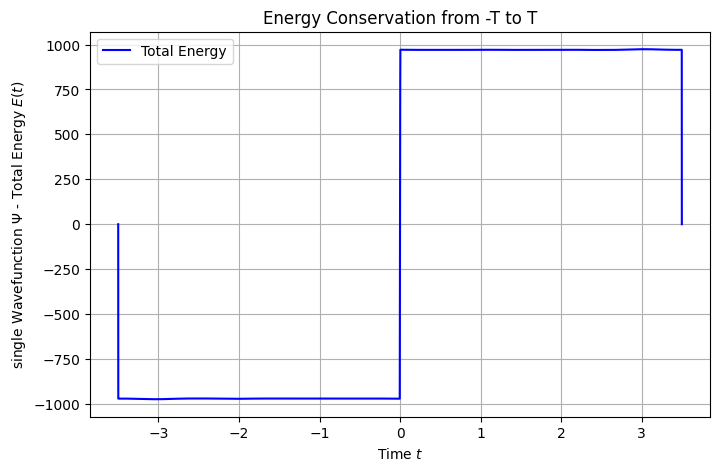

In [13]:
simulator = QuantumWaveSimulator(L=10, T=3.5, c=1, dx=0.001, dt=0.001, m=1)
simulator.initialize_particle(mode="single", A=1, k=2 * np.pi, phi=0)
simulator.set_single_barrier_potential(height=-11, width=0.3, center=0)
simulator.solve(include_potential=True)
simulator.visualize_energy(name="scattering")

# simulator.visualize_wave(show_phase=True)
# simulator.visualize_2D_ripple_polar(show_phase=True)
#simulator.visualize_3D_ripple_polar(show_phase=True)
#plt.savefig("scattering_wavefunction.png")

In [ ]:
simulator = QuantumWaveSimulator(L=10, T=3.5, c=1, dx=0.001, dt=0.001, m=1)
simulator.initialize_particle(mode="single", A=1, k=2 * np.pi, phi=0)
simulator.set_single_barrier_potential(height=-11, width=0.3, center=0)
simulator.solve(include_potential=True)
simulator.visualize_energy(name="scattering")

# simulator.visualize_wave(show_phase=True)
# simulator.visualize_2D_ripple_polar(show_phase=True)
#simulator.visualize_3D_ripple_polar(show_phase=True)
#plt.savefig("scattering_wavefunction.png")

In [4]:
import time
from memory_profiler import memory_usage

def benchmark(func, *args, **kwargs):
    """
    Benchmark the execution time and memory usage of a function.
    
    Parameters:
    - func: Function to be executed.
    - args: Positional arguments for the function.
    - kwargs: Keyword arguments for the function.
    
    Returns:
    - result: The output of the function call.
    - elapsed_time: Time taken for the function to execute in seconds.
    - peak_memory: Peak memory usage in MB.
    """
    start_time = time.time()
    mem_usage = memory_usage((func, args, kwargs))  # Returns a list of memory usage over time
    elapsed_time = time.time() - start_time
    peak_memory = max(mem_usage)  # Get the peak memory usage
    result = func(*args, **kwargs)
    return result, elapsed_time, peak_memory

In [ ]:


def solve_kg_equation():
    simulator = QuantumWaveSimulator(L=10, T=5, c=1, dx=0.01, dt=0.01, m=1)
    simulator.initialize_particle(mode="single", A=1, k=2 * np.pi, phi=0)
    simulator.solve()

# Benchmark the Klein-Gordon solver
_, kg_time, kg_memory = benchmark(solve_kg_equation)
print(f"Klein-Gordon Solver: Time = {kg_time:.4f}s, Memory = {kg_memory:.2f} MB")

Klein-Gordon Solver: Time = 0.6412s, Memory = 168.67 MB


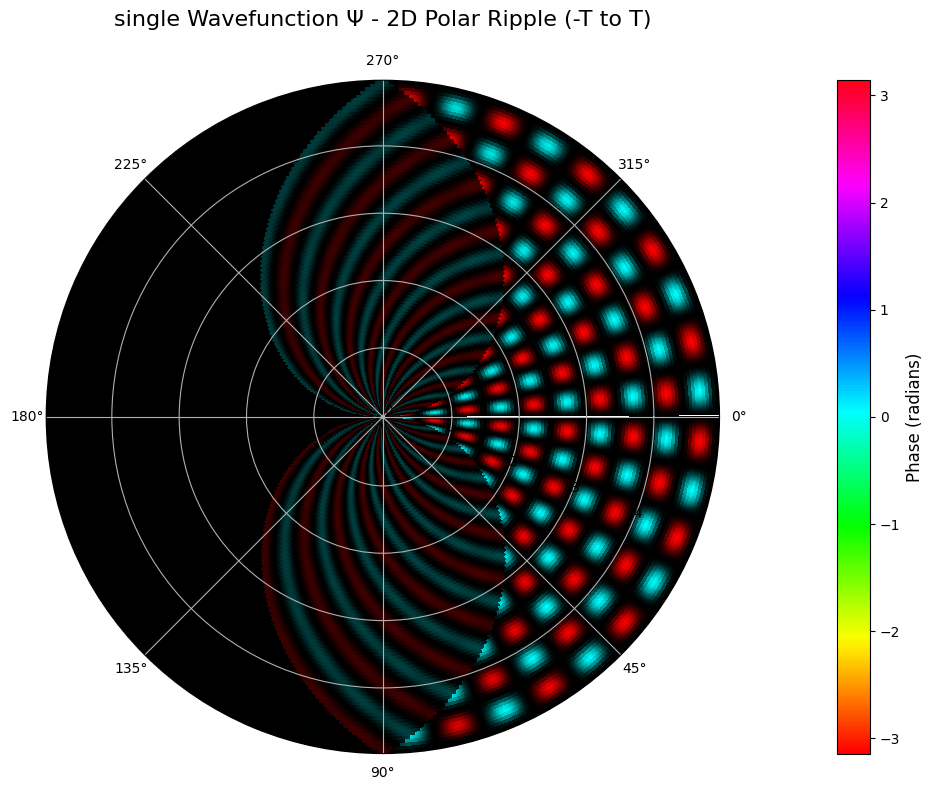

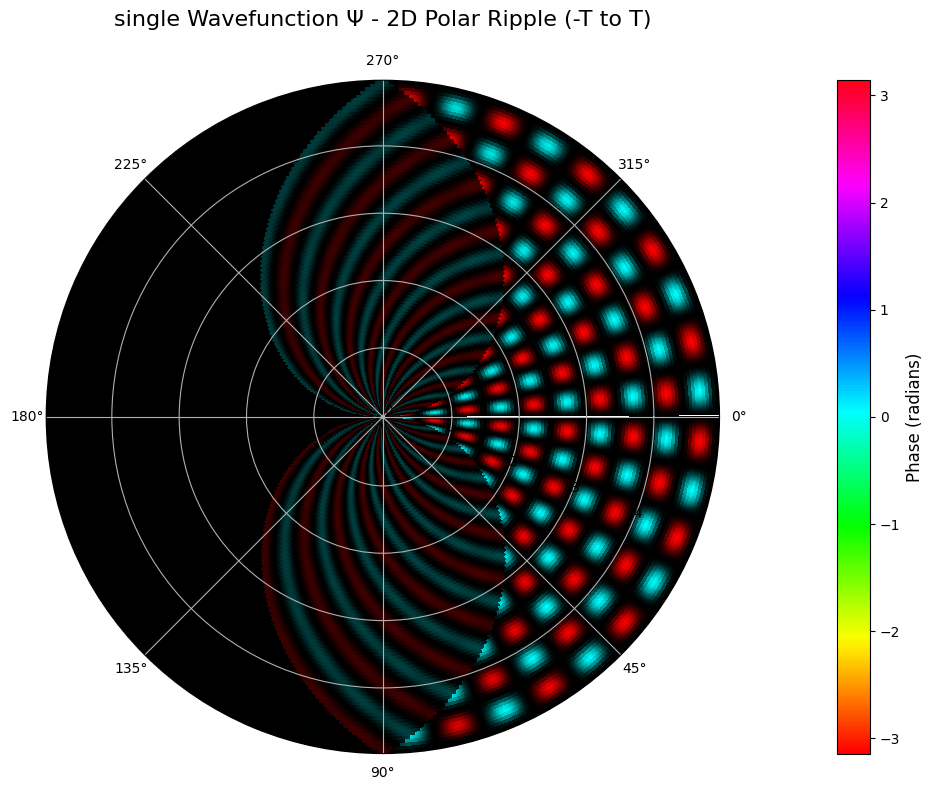

Polar Mapping: Time = 0.8114s, Memory = 283.72 MB


In [29]:
def map_to_polar_coordinates():
    simulator = QuantumWaveSimulator(L=10, T=5, c=1, dx=0.01, dt=0.01, m=1)
    simulator.initialize_particle(mode="single", A=1, k=2 * np.pi, phi=0)
    simulator.solve()
    simulator.visualize_2D_ripple_polar(show_phase=True)

polar_result, polar_time, polar_memory = benchmark(map_to_polar_coordinates)
print(f"Polar Mapping: Time = {polar_time:.4f}s, Memory = {polar_memory:.2f} MB")

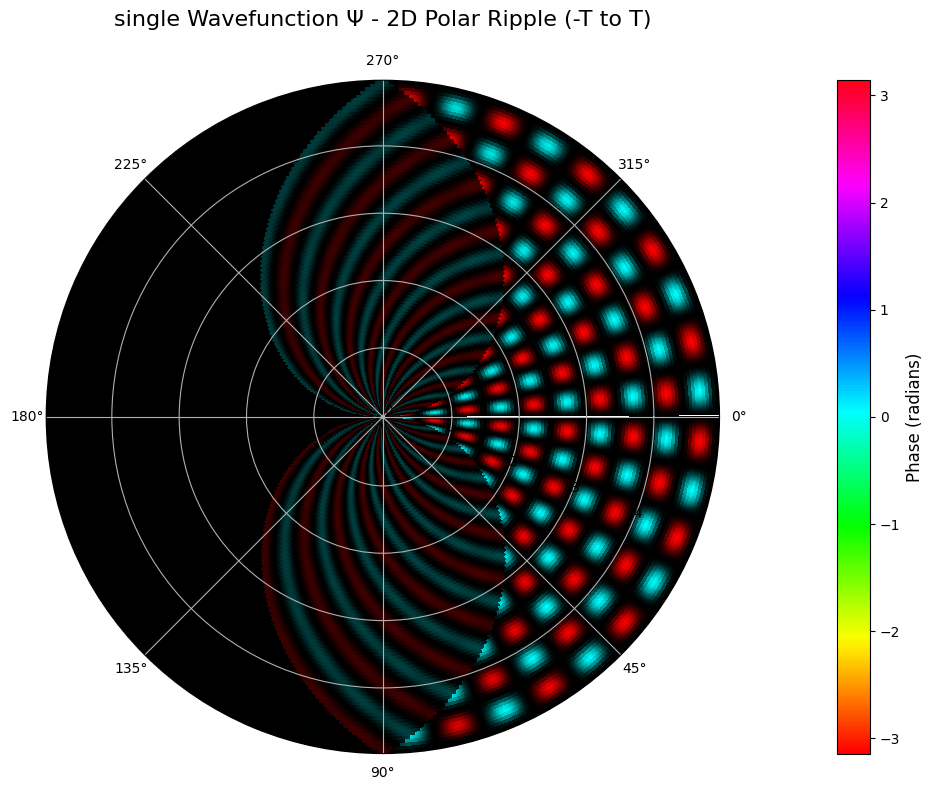

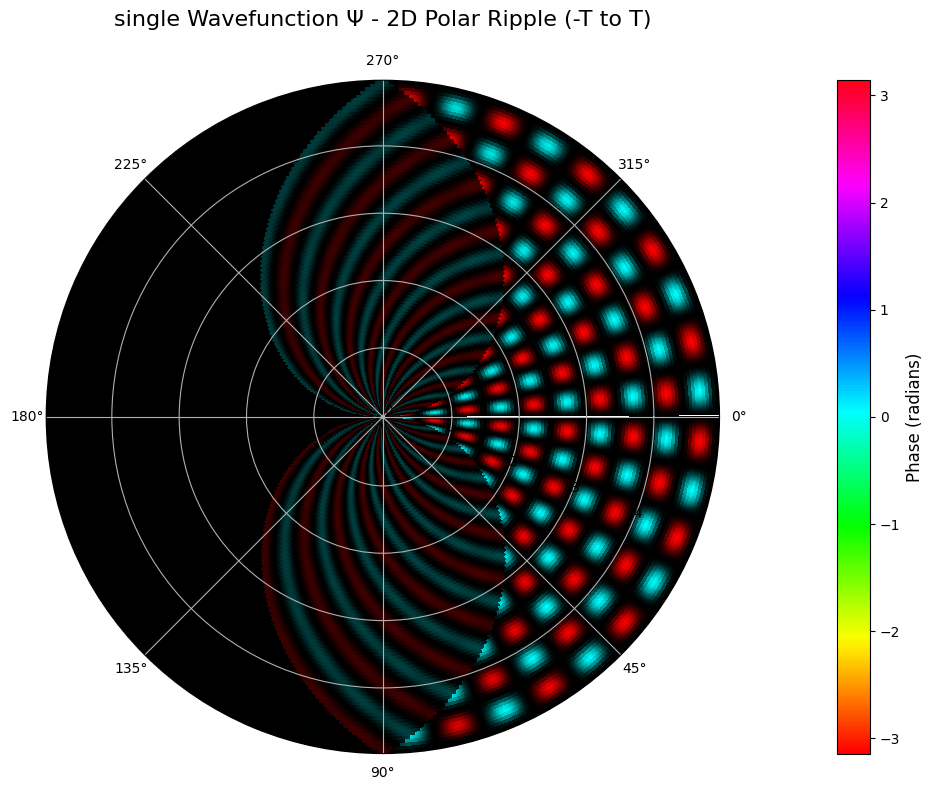

2D Polar Visualization: Time = 0.6675s, Memory = 368.02 MB


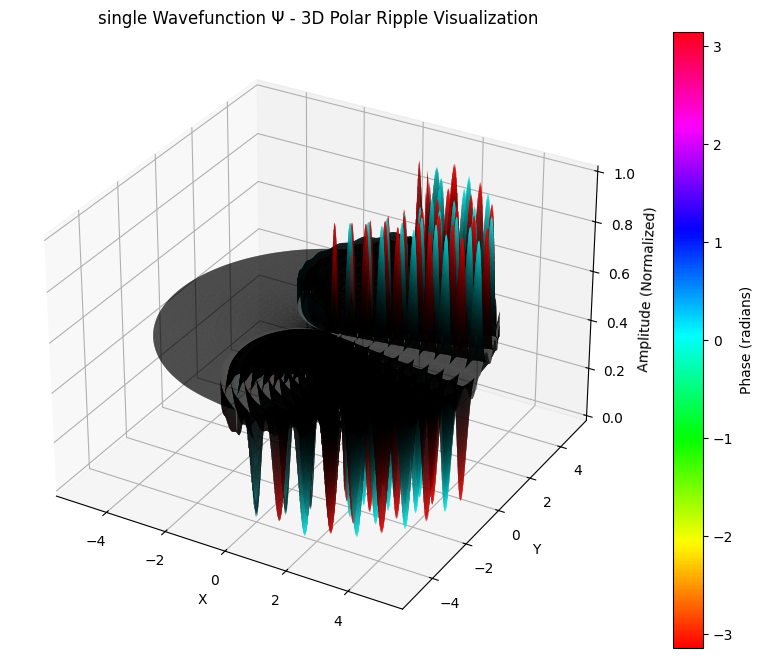

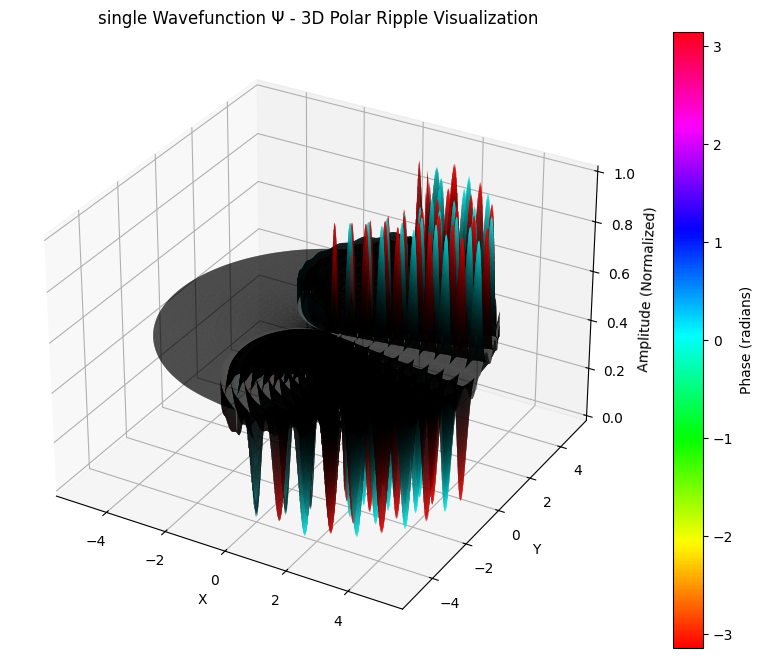

3D Polar Visualization: Time = 50.8877s, Memory = 2969.41 MB


In [30]:
def visualize_2d_polar():
    simulator = QuantumWaveSimulator(L=10, T=5, c=1, dx=0.01, dt=0.01, m=1)
    simulator.initialize_particle(mode="single", A=1, k=2 * np.pi, phi=0)
    simulator.solve()
    simulator.visualize_2D_ripple_polar(show_phase=True)

_, vis_2d_time, vis_2d_memory = benchmark(visualize_2d_polar)
print(f"2D Polar Visualization: Time = {vis_2d_time:.4f}s, Memory = {vis_2d_memory:.2f} MB")

def visualize_3d_polar():
    simulator = QuantumWaveSimulator(L=10, T=5, c=1, dx=0.01, dt=0.01, m=1)
    simulator.initialize_particle(mode="single", A=1, k=2 * np.pi, phi=0)
    simulator.solve()
    simulator.visualize_3D_ripple_polar(show_phase=True)

_, vis_3d_time, vis_3d_memory = benchmark(visualize_3d_polar)
print(f"3D Polar Visualization: Time = {vis_3d_time:.4f}s, Memory = {vis_3d_memory:.2f} MB")

             Method  Runtime (s)  Memory Usage (MB)
0   Wigner Function     9.867722          15.291426
1    Density Matrix     0.000935           7.778702
2  Ripple Framework     3.588598          29.369516


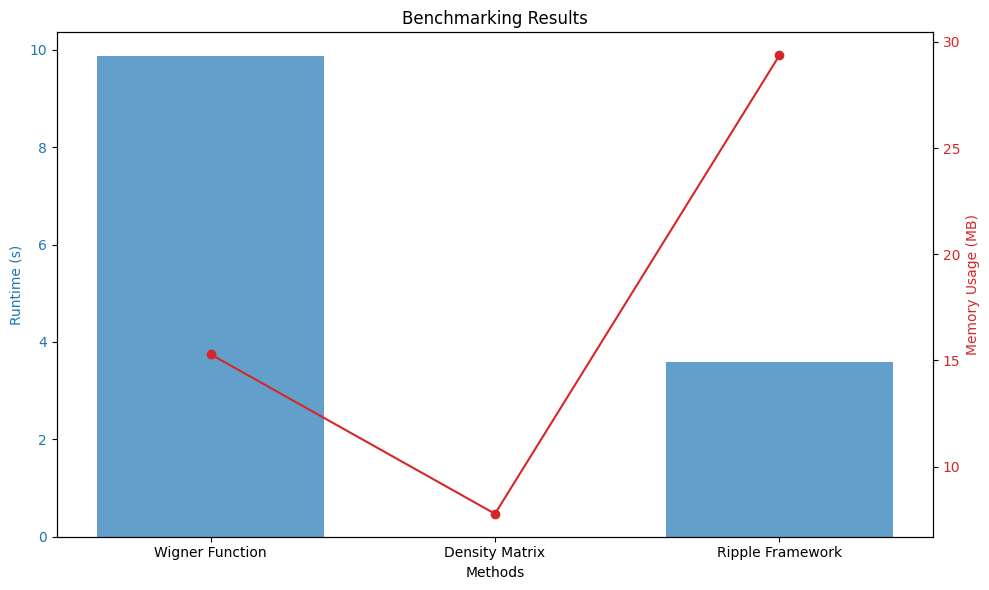

In [6]:
import numpy as np
from scipy.signal import fftconvolve
import time
import psutil
import tracemalloc

def benchmark(func, *args, **kwargs):
    """
    Benchmark the execution time and memory usage of a function.

    Parameters:
    - func: Function to be executed.
    - args: Positional arguments for the function.
    - kwargs: Keyword arguments for the function.

    Returns:
    - runtime: Time taken for the function to execute in seconds.
    - memory_usage: Peak memory usage during execution in MB.
    """
    tracemalloc.start()  # Start memory tracking
    start_time = time.time()
    func(*args, **kwargs)  # Execute the function
    runtime = time.time() - start_time  # Compute runtime
    _, peak_memory = tracemalloc.get_traced_memory()  # Get peak memory usage
    tracemalloc.stop()  # Stop memory tracking

    # Convert memory usage to MB
    memory_usage = peak_memory / (1024 * 1024)

    return runtime, memory_usage

def wigner_function(simulator):
    """
    Compute a simplified Wigner function for the wavefunction.
    """
    wavefunction = simulator.Psi[0, :]
    x = simulator.x
    wigner = np.zeros((len(x), len(x)), dtype=complex)

    for i, x_i in enumerate(x):
        for j, x_j in enumerate(x):
            shift = (x_j - x_i) / 2
            left = x_i + shift
            right = x_i - shift

            if left >= x[0] and right <= x[-1]:
                wigner[i, j] = wavefunction[int((left - x[0]) / simulator.dx)] * \
                               np.conj(wavefunction[int((right - x[0]) / simulator.dx)])
    return np.real(wigner)

def density_matrix(simulator):
    """
    Compute the density matrix of the wavefunction.
    """
    wavefunction = simulator.Psi[0, :]
    return np.outer(wavefunction, np.conj(wavefunction))

def ripple_framework(simulator):
    """
    Compute amplitude and phase visualizations using the ripple-based framework.
    """
    simulator.solve()  # Solve the Klein-Gordon equation
    final_wavefunction = simulator.Psi[-1, :]
    amplitude = np.abs(final_wavefunction)
    phase = np.angle(final_wavefunction)
    return amplitude, phase

# Initialize the simulator
simulator = QuantumWaveSimulator(L=10, T=5, c=1, dx=0.01, dt=0.01, m=1)
simulator.initialize_particle(mode="single", A=1, k=2 * np.pi, phi=0)

# Benchmark Wigner function
wigner_time, wigner_memory = benchmark(wigner_function, simulator)

# Benchmark Density Matrix
density_time, density_memory = benchmark(density_matrix, simulator)

# Benchmark Ripple Framework
ripple_time, ripple_memory = benchmark(ripple_framework, simulator)

# Collect Results
results = [
    {"Method": "Wigner Function", "Runtime (s)": wigner_time, "Memory Usage (MB)": wigner_memory},
    {"Method": "Density Matrix", "Runtime (s)": density_time, "Memory Usage (MB)": density_memory},
    {"Method": "Ripple Framework", "Runtime (s)": ripple_time, "Memory Usage (MB)": ripple_memory},
]

# Convert results to DataFrame for readability
import pandas as pd
df = pd.DataFrame(results)

# Display Results
print(df)

# Plot Results
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(df["Method"], df["Runtime (s)"], color="tab:blue", alpha=0.7, label="Runtime (s)")
ax1.set_xlabel("Methods")
ax1.set_ylabel("Runtime (s)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.plot(df["Method"], df["Memory Usage (MB)"], color="tab:red", marker="o", label="Memory Usage (MB)")
ax2.set_ylabel("Memory Usage (MB)", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

plt.title("Benchmarking Results")
fig.tight_layout()
plt.savefig(f'comparison_plot.png')
plt.show()